In [1]:
import ctd
import gsw
from ctd.read import _basename


def derive_cnv(cast):
    """Compute SP, SA, CT, z, and GP from a cnv pre-processed cast."""
    p = cast.index.values.astype(float)
    lon = cast._metadata.get("lon")
    lat = cast._metadata.get("lat")

    SP = gsw.SP_from_C(cast["c0S/m"] * 10., cast["t090C"], p)
    cast["SA"] = gsw.SA_from_SP(SP, p, lon, lat)
    cast["CT"] = gsw.CT_from_t(cast["SA"], cast["t090C"], p)
    cast["z"] = -gsw.z_from_p(p, lat)
    cast["sigma0_CT"] = gsw.sigma0(cast["SA"], cast["CT"])
    return cast


def proc_ctd(fname):
    # read and fill metadata
    cast = ctd.from_cnv(fname).split()[0]

    name = _basename(str(fname))[1]
    lat = cast["latitude"].mean()
    lon = cast["longitude"].mean()

    # 00-split, clean "bad pump" data, and apply flag
    cast = cast[cast["pumps"]]
    cast = cast[~cast["flag"]]  # True for bad values.

    # 03-loop edit
    cast["dz/dtM"] = cast["dz/dtM"].movingaverage(window_size=48)
    cast = cast[cast["dz/dtM"] >= 0.25]  # Threshold velocity.

    # from now on we'll only need in site temperature and conductivity.
    cols = [ "t090C", "c0S/m"]
    cast = cast[cols]

    cast = cast.remove_above_water()\
               .lp_filter()\
               .press_check()\
               .dropna()\
               .despike(n1=2, n2=20, block=100)\
    
    cast._metadata = {"name": name, "lat": lat, "lon": lon}

    # 08-Derive.
    cast = derive_cnv(cast)
    
    cast = cast.set_index("z")
    cast = cast.bindata(delta=1, method="interpolate")
    cast._metadata = {"name": name, "lat": lat, "lon": lon}
    return cast

In [2]:
from pathlib import Path


path = Path("..", "tests", "data", "CTD")


def alphanum_key(s):
    import re
    s = str(s)
    key = re.split(r"(\d+)", s)
    key[1::2] = map(int, key[1::2])
    return key

fnames = sorted(
    path.glob("*c.cnv.gz"),
    key=alphanum_key
)

ctd_casts = [proc_ctd(fname) for fname in fnames]

In [3]:
lons, lats = [], []

for cast in ctd_casts:
    lons.append(cast._metadata.get("lon"))
    lats.append(cast._metadata.get("lat"))

dx = dy = 2
bbox = min(lons)-dx, max(lons)+dx, min(lats)-dy, max(lats)+dy

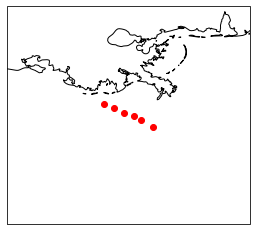

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# https://ocefpaf.github.io/python4oceanographers/blog/2013/07/29/python-ctd/
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={"projection": projection})
ax.set_extent(bbox)
ax.coastlines()
ax.plot(lons, lats, "ro");

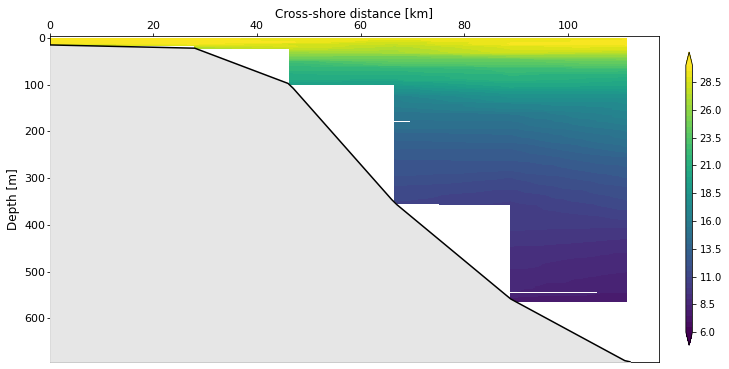

In [5]:
from ctd.extras import *

from gsw import distance
import pandas as pd


def plot_section(ctd_casts, var, reverse=False, **kw):
    names = [df._metadata.get("name") for df in ctd_casts]
    lons, lats, data = [], [], []
    for cast in ctd_casts:
        lons.append(cast._metadata.get("lon"))
        lats.append(cast._metadata.get("lat"))
        data.append(cast[var])


    sec = pd.concat(data, axis=1)
    sec.columns = names

    z = sec.index.values
    h = get_maxdepth(sec)

    lons, lats = map(np.atleast_2d, (lons, lats))
    x = np.append(0, np.cumsum(distance(lons, lats)[0] / 1e3))
    z = sec.index.values.astype(float)
    data = ma.masked_invalid(sec)

    if reverse:
        lons = lons[::-1]
        lats = lats[::-1]
        data = data.T[::-1].T
        h = h[::-1]

    # Contour key words.
    extend = kw.pop("extend", "both")
    fontsize = kw.pop("fontsize", 12)
    labelsize = kw.pop("labelsize", 11)
    cmap = kw.pop("cmap", None)
    levels = kw.pop(
        "levels", np.arange(np.floor(np.nanmin(data)), np.ceil(np.nanmax(data)) + 0.5, 0.5),
    )

    # Colorbar key words.
    pad = kw.pop("pad", 0.04)
    aspect = kw.pop("aspect", 40)
    shrink = kw.pop("shrink", 0.9)
    fraction = kw.pop("fraction", 0.05)

    # Topography mask key words.
    dx = kw.pop("dx", 1.0)
    kind = kw.pop("kind", "linear")
    linewidth = kw.pop("linewidth", 1.5)

    # Station symbols key words.
    station_marker = kw.pop("station_marker", None)
    color = kw.pop("color", "k")
    offset = kw.pop("offset", -5)
    alpha = kw.pop("alpha", 0.5)

    # Figure.
    figsize = kw.pop("figsize", (12, 6))
    fig, ax = plt.subplots(figsize=figsize)
    xm, hm = gen_topomask(h, lons, lats, dx=dx, kind=kind)
    ax.plot(xm, hm, color="black", linewidth=linewidth, zorder=3)
    ax.fill_between(xm, hm, y2=hm.max(), color="0.9", zorder=3)

    if station_marker:
        ax.plot(
            x,
            [offset] * len(h),
            color=color,
            marker=station_marker,
            alpha=alpha,
            zorder=5,
        )
    ax.set_xlabel("Cross-shore distance [km]", fontsize=fontsize)
    ax.set_ylabel("Depth [m]", fontsize=fontsize)
    ax.set_ylim(offset, hm.max())
    ax.invert_yaxis()

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.xaxis.set_tick_params(tickdir="out", labelsize=labelsize, pad=1)
    ax.yaxis.set_tick_params(tickdir="out", labelsize=labelsize, pad=1)

    cs = ax.contourf(
        x, z, data, cmap=cmap, levels=levels, alpha=1.0, extend=extend, zorder=2,
    )

    cb = fig.colorbar(
        mappable=cs,
        ax=ax,
        orientation="vertical",
        aspect=aspect,
        shrink=shrink,
        fraction=fraction,
        pad=pad,
    )
    return fig, ax, cb


fig, ax, cb = plot_section(ctd_casts, var="CT", reverse=True, filled=True)